# Normalizing Radar Cross Sections

The premise of microwave remote sensing is measuring the amplitude or energy of an EM wave, given by $E_0$, and the related concept of energy per unit of time, given by $P$ (with unit Watts). Radar imaging measures power over distributed areas where we want to know how much scattered energy is returned to the radar system.  This can be expressed as a ratio between scattered power ($P_s$) and incident power ($P_i$), so that:

$$\sigma = \frac{P_s}{Pi} 4 \pi R^2 \, [m^2] \quad \text{,} \quad  \text{(equation 1)}$$

provides a backscatter coefficient for distributed targets per given reference area, also known as a radar scattering cross section. 

For backscattering from ground surfaces an increasingly larger target area will increase the total backscattered power by the same factor, and so the radar cross sections changes with the size of illuminated area. To accommodate for this undesirable aspect, which does not represent a faithful description of the target ground area, radar cross sections are normalized by an approximation of the illuminated ground area measured, as follows:

$$\sigma^0 = \sigma /  \hat{A} \, [1] \quad \text{.} \quad  \text{(equation 2)}$$

Backscattering can be highly dependent on the angle of the incident energy when the targetted area is signified by reflective objects of different heights, such as trees. This phenomenon is called volume scattering and can be accounted for by again normalizing with the cosine of the local incidence angle:

$$\gamma^0 = \sigma^0 / \cos{\theta_i} \, [1] \quad \text{.} \quad  \text{(equation 3)} $$ 

Now let's have a look at some backscatter coefficients ($\gamma^0$ = gmr, $\sigma^0$ = sig0) and the local incidence angle (plia) over an area around the city of Modena, Italy.

## Loading Normalized Backscatter Data

We first load the data with `xarray`, select an area of interest (AOI), and modify the variables `gmr`, `sig0`, and `plia` by dividing by 100. The latter step is necessary as the variables have been multiplied by 100 allowing more efficient storage of the data thereby decreasing the file size.

In [1]:
import xarray as xr
import rioxarray
from pathlib import Path
import folium
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def _preprocess(x):
    x = x / 100
    return x.rename({"band_data": Path(x.encoding["source"]).parent.stem}).squeeze("band").drop_vars("band")

ds = xr.open_mfdataset("../data/A0105/EQUI7_EU010M/E047N012T1/**/*.tif", engine="rasterio", combine='nested', preprocess=_preprocess)
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 10000, y: 10000)
Coordinates:
  * x            (x) float64 80kB 4.7e+06 4.7e+06 4.7e+06 ... 4.8e+06 4.8e+06
  * y            (y) float64 80kB 1.3e+06 1.3e+06 1.3e+06 ... 1.2e+06 1.2e+06
    spatial_ref  int64 8B 0
Data variables:
    gmr          (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>
    plia         (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>
    sig0         (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>

## Area of Interest

Let's have a closer look at the area of interest by taking the bounding box of the `xarray` Dataset with `rioxarray` method `transform_bounds` and using this to define the viewing window on a [leaflet](https://leafletjs.com/) map with `folium`.

In [3]:
ds_aoi = ds.sel(x=slice(4.78e6, 4.795e6), y=slice(1.28e6, 1.265e6)).compute()

bbox = ds_aoi.rio.transform_bounds("EPSG:4326")

folium.Map(
    max_bounds=True,
    location=[bbox[1] + (bbox[3] - bbox[1]) / 2, bbox[0] + (bbox[2] - bbox[0]) / 2],
    min_lat=bbox[1],
    max_lat=bbox[3],
    min_lon=bbox[0],
    max_lon=bbox[2],
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

*Figure1: Map of the target area.*

## Visualizing the Backscatter Coefficients

Now we can visualize the backscatter coefficients by using the `xarray` method `plot`,  and by plotting these on a `matplotlib` figure with 2  `axes` (i.e., representing the subplots on a multipanel figure).

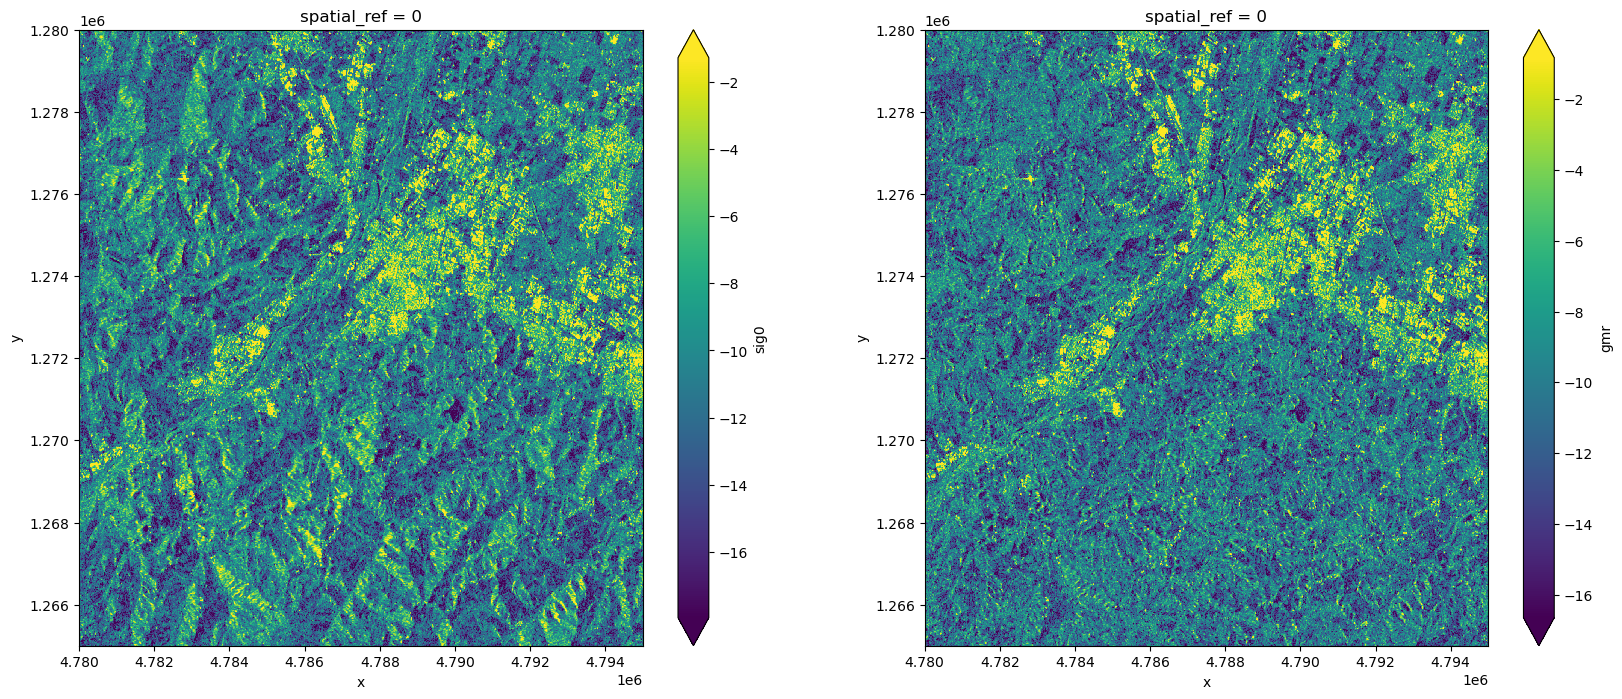

In [4]:
fig, ax  = plt.subplots(1,2, figsize=(20,8))

ds_aoi.sig0.plot(ax=ax[0], robust=True)
ds_aoi.gmr.plot(ax=ax[1], robust=True)

*Figure 2: The $\sigma^o$ (left) and $\gamma^o$ (right) from the JupyterHub shared folder plotted on a 2D map*

Now let's have a look at how the local incidence angles look like when plotted on 2D map and compare it with $\sigma^o$.

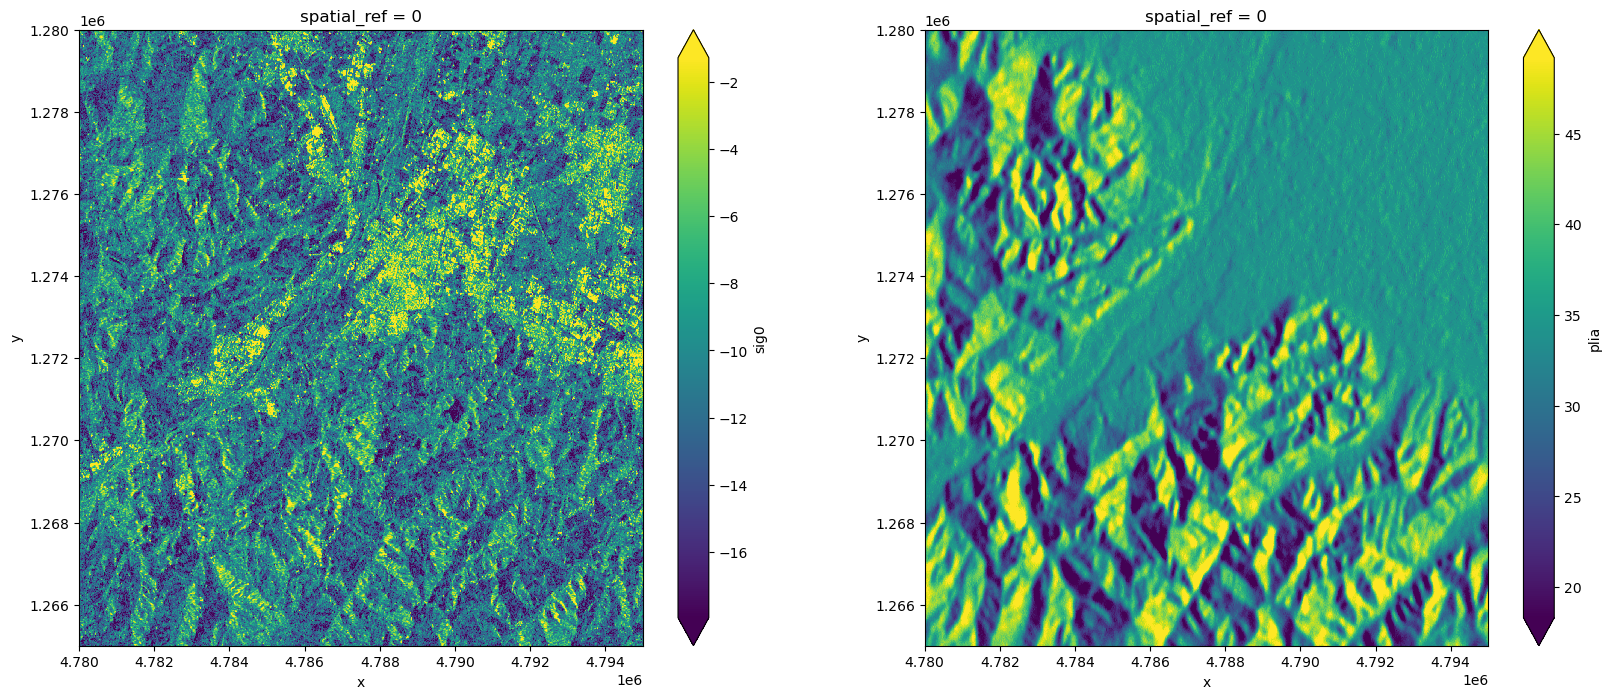

In [5]:
fig, ax  = plt.subplots(1,2, figsize=(20,8))

ds_aoi.sig0.plot(ax=ax[0], robust=True)
ds_aoi.plia.plot(ax=ax[1], robust=True)

*Figure 3: The $\sigma^o$ (left) and local incidence angle (plia: right) from the JupyterHub shared folder plotted on a 2D map*

## Calculating $\gamma^o$ with `numpy`

It is clear by looking at the local incidence angles that the area is marked by topographically severe terrain. One of the data treatments corrected for the features related to rough terrain in Figure 1, whereas the other did not.

Let's now look at what the choice of backscatter coefficient ($\sigma^0$ or $\gamma^0$) has on the data. We do this by first converting $\sigma^0$ to $\gamma^0$ with equation 3, like so:

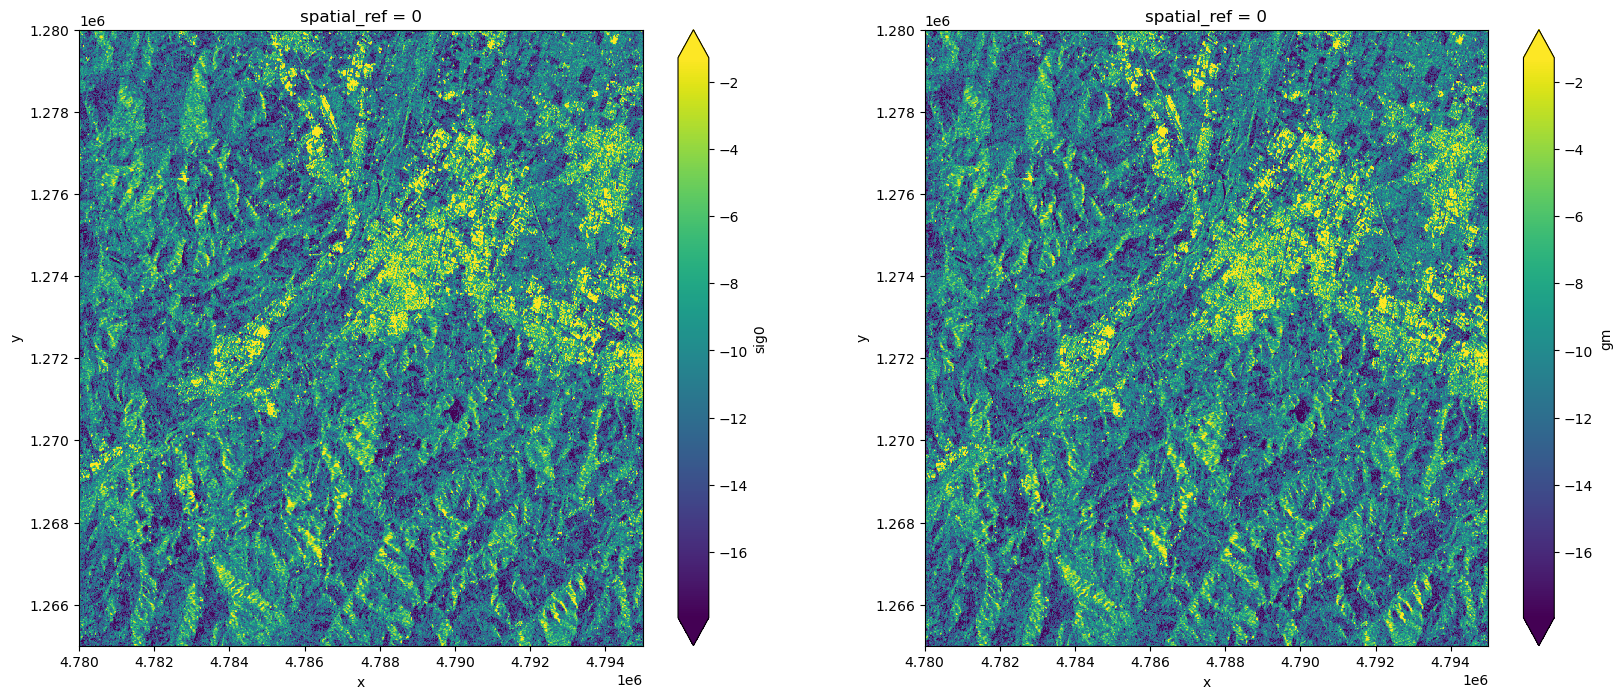

In [6]:
ds_aoi["gm"] = ds_aoi.sig0 / np.cos(np.radians(ds_aoi.plia / 100))

fig, ax  = plt.subplots(1,2, figsize=(20,8))

ds_aoi.sig0.plot(ax=ax[0], robust=True)
ds_aoi.gm.plot(ax=ax[1], robust=True)

*Figure 4: The $\sigma^o$ (left) from the JupyterHub shared folder and the derived $\gamma^0$ plotted on a 2D map*

# Radiometric Terrain Correction

Clearly the choice of backscatter coefficient alone is not the full story. The main difference in backscatter coefficients in Figure 2 relates to the approximation of the geometrical area used for the normalization (Figure 5). The approximation of illuminated ground area for $\sigma^0$ is calculate by a tangent on an ellipsoid model for the Earth. The $\gamma^0$ backscatter coefficient in the original data was generated with a terrain flattening method; integrating through a reference digital elevation model to determine the local illuminated area at each radar position (Figure 5; referred to as *Sampled pixel area*).

![Woodhouse, 2006](../assets/images/woodhouse2006_chapter5_figure5.4.png)

*Figure 5: Three different ways in which to normalise by area (Woodhouse 2006).*

## References

Woodhouse, Ian H., 2006, Introduction to Microwave Remote Sensing, Chapter 5: Microwaves in the Real World, pp 93--149, CRS Press